Answer the following questions:



1. What are the advantages and disadvantages of Latent Variable Models? Explain.
2. Explain the differences between Forward KL and Backward KL divergences? Which is used in ELBO maximization and why? 
3. Why do we use variational inference instead of Maximum likelihood estimation or expectation maximization techniques to maximize the likelihood, $p_{\boldsymbol{\theta}}(\mathbf{X})$? 
4. Why do we maximize the Evidence Lower Bound (ELBO) to maximize the true marginal likelihood? Explain the two ways of derivation of the ELBO and state the key mathematical concepts in these derivations.
5. What is the reason for the need of the reparameterization trick?
6. What is amortized inference and what is its advantage? 





#VAE Implementation

Complete the code where # YOUR CODE HERE has been stated. 


* VAE implementation task is modified from Deep Learning Course exercises at Aalto University.

In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive')
## Update directory 
base_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Latent Variable Models'
sys.path.insert(0, base_dir)

Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tools
import tests

In [3]:
skip_training = False
data_dir = './data'

In [4]:
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [5]:
# We will use varianceMNIST data in this exercise
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Lambda(lambda x: x * torch.randn_like(x))
])

trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


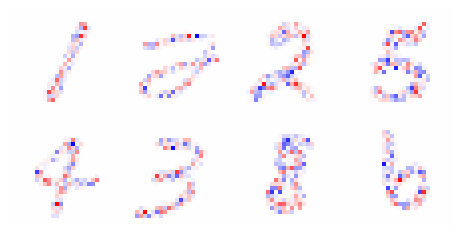

In [6]:
images, labels = iter(trainloader).next()
tools.plot_images(images[:8], ncol=4, cmap=plt.cm.bwr, clim=[-3,3])

# Variational autoencoder (VAE)

In this exercise, we will assume the following generative model for the data:
* the latent codes are normally distributed:
$$
  p(z) = \mathcal{N}(z \mid 0, I)
$$
where $I$ is the identity matrix.
* the data are produced from the latent codes as follows:
$$
  p(x \mid z) =\mathcal{N}\left(x \mid \mu_x(z), \:\text{diag}(\sigma^2_x(z)) \right)
$$
where $\mu_x(z)$ and $\sigma^2_x(z)$ are some deterministic functions that we need to learn.

## Encoder

In the cell below, your task is to implement the encoder of a VAE.

The two heads are needed to produce two outputs of the encoder:
* means $\mu_z$ of the approximate distribution of the latent code $\bar z$
* log-variance $\tilde z$ of the approximate distribution of the latent code $z$.
To guarantee that the variance is positive, we parameterize it as $\sigma_z^2 = \exp(\tilde z)$.


In [ ]:
class Encoder(nn.Module):
    def __init__(self, n_components):
        # YOUR CODE HERE  
        
    def forward(self, x):
        # YOUR CODE HERE

    def sample(self, z_mean, z_logvar):
        """Draw one sample from the posterior of the latent codes described by given parameters.
        This is needed for the re-parameterization trick.
        
        Args:
          z_mean of shape (batch_size, n_components): Means of the approximate distributions of the codes.
          z_logvar of shape (batch_size, n_components): Log-variance of the approximate distributions of the codes.
        
        Returns:
          z of shape (batch_size, n_components): Drawn samples.
        """
        # YOUR CODE HERE

In [ ]:
def test_Encoder_shapes():
    n_components = 10 # dimensional latent space
    encoder = Encoder(n_components=n_components)

    x = torch.randn(3, 1, 28, 28)
    mu, logsigma = encoder(x)
    assert mu.shape == torch.Size([3, n_components]), f"Bad mu.shape: {mu.shape}"
    assert logsigma.shape == torch.Size([3, n_components]), f"Bad logsigma.shape: {logsigma.shape}"
    print('Success')

test_Encoder_shapes()

In [ ]:
def test_Encoder_sample():
    n_components = 10 # dimensional latent space
    encoder = Encoder(n_components=n_components)

    z_mean = torch.zeros(3, n_components)
    z_logvar = torch.log(2*torch.ones(3, n_components))
    z = encoder.sample(z_mean, z_logvar)
    assert z.shape == z_mean.shape, f"Bad z.shape: {z.shape}"
    print('Success')

test_Encoder_sample()

### Kullback-Leibler divergence loss

One term of the loss function minimized during training of a VAE is the Kullback-Leibler divergence between the approximate distribution of the latent codes $q(z) = \mathcal{N}(z \mid \mu_z, \sigma^2_z)$ and the prior distribution $p(z) = \mathcal{N}(z \mid 0, I)$:
$$
\frac{1}{N} \sum_{i=1}^N \int q(z_i) \log \frac{q(z_i)}{p(z_i)} dz_i
$$
where $N$ is the number of samples (batch size in our implementation).

We will implement this loss function in the cell below.

Note: Please do **not** use functions from `torch.distributions` module. 


In [ ]:
def loss_kl(z_mean, z_logvar):
    """
    Args:
      z_mean of shape (batch_size, n_components): Means of the approximate distributions of the codes.
      z_logvar of shape (batch_size, n_components): Log-variance of the approximate distributions of the codes.
    
    Returns:
      loss (torch scalar): Kullback-Leibler divergence.
    """
    # YOUR CODE HERE

In [ ]:
def test_loss_kl():
    n_components = 2
    z_mean = torch.zeros(3, n_components)
    z_logvar = torch.log(2*torch.ones(3, n_components))
    loss = loss_kl(z_mean, z_logvar)
    expected = torch.tensor(0.3068528175354004)
    print('loss:', loss.item())
    print('expected:', expected.item())
    assert torch.allclose(loss, expected, atol=1e-5), "loss does not match expected value."
    print('Success')

test_loss_kl()

## Decoder

The decoder computes the predictive distribution of the data given latent code $z$ according to our
assumed generative model:
$$
  p(x \mid z) = \mathcal{N}\left(x \mid \mu_x(z), \sigma^2_x(z) \right)
$$
where $\mu_x(z)$ and $\sigma^2_x(z)$ are some deterministic functions that we need to learn.

You can use the following architecture for the decoder:
* Fully-connected layer with 250 output features, followed by ReLU
* Fully-connected layer with 250 input features, followed by ReLU
* `ConvTranspose2d` layer with kernel size 5 with 16 input channels, followed by ReLU
* Two heads made of `ConvTranspose2d` layer with kernel size 5 with 6 input channels.

The two heads are needed to produce two outputs of the decoder:
* means $\mu_x$ of the predictive distribution of the data
* log-variance $\tilde x$ of the predictive distribution of the data.
To guarantee that the variance is positive, we parameterize it as $\sigma_x^2 = \exp(\tilde x)$.

**Important:**

In practice, learning the proposed generative model is difficult for the varianceMNIST dataset. The problem is that the background pixels have zero variances, which corresponds to infinitely low loss values. Thus, training may concentrate entirely on modeling the variance of the background pixels. To prevent this, we define the minimum allowed value of the predictive variance $\tilde x$ and save it in the model as
```
    self.register_buffer('min_logvar', -6 * torch.ones(1))
```
We need to use `register_buffer` to make sure that the variable is on the same device as the trained parameters of the model. We can use this code in the forward function to limit the predicted variance by `self.min_logvar`:
```
logvar = self.min_logvar + F.softplus(logvar - self.min_logvar)
```

In [ ]:
class Decoder(nn.Module):
    def __init__(self, n_components):
        # YOUR CODE HERE

    def forward(self, x):
        # YOUR CODE HERE

In [ ]:
def test_Decoder_shapes():
    n_components = 10 # dimensional latent space
    decoder = Decoder(n_components=n_components)

    z = torch.randn(3, n_components)
    y_mean, y_logvar = decoder(z)
    y_shape = torch.Size([3, 1, 28, 28])
    assert y_mean.shape == y_shape, "Bad shape of y_mean: y_mean.shape={}".format(y_mean.shape)
    assert y_logvar.shape == y_shape, "Bad shape of y_logvar: y_logvar.shape={}".format(y_logvar.shape)
    print('Success')

test_Decoder_shapes()

### Expected log-likelihood term

The second term of the VAE loss function is minus log-likelihood estimated using sample $z_i$ from the approximate distribution $q(z_i)$ of the latent code that corresponds to training example $x_i$.

$$
- \int q(z_i) \log \mathcal{N}\left(x_i \mid \mu_x(z_i), \:\text{diag}(\sigma^2_x(z_i))\right) dz_i
$$
where $\mathcal{N}(x_i)$ is a multivariate normal distribution over all pixel values of image $x_i$.

Your task is to implement that function **without** constant terms
$$
\frac{28 \cdot 28}{2} \log 2 \pi
$$
that do not depend on $\mu_x(z_i)$ or $\sigma_x(z_i)$.

In [ ]:
def loss_loglik(y_mean, y_logvar, x):
    """
    Args:
      y_mean of shape : Predictive mean of the VAE reconstruction of x.
      y_logvar of shape : Predictive log-variance of the VAE reconstruction of x.
      x of shape : Training samples.
    
    Returns:
      loss (torch scalar): Expected log-likelihood loss.
    """
    # YOUR CODE HERE

In [ ]:
def test_loss_loglik():
    y_mean = torch.zeros(1, 1, 28, 28)
    y_logvar = torch.log(2*torch.ones(1, 1, 28, 28))
    y_logvar[:,:,:14,:] = torch.log(torch.ones(1, 1, 14, 28))

    x = torch.zeros(1, 1, 28, 28)
    x[:,:,:14,:] = torch.zeros(1, 1, 14, 28)

    loss = loss_loglik(y_mean, y_logvar, x)
    expected = torch.tensor(135.85682678222656)
    
    print('loss:', loss)
    print('expected:', expected)
    assert torch.allclose(loss, expected), "loss does not match expected value."
    print('Success')

test_loss_loglik()

# Train a variational autoencoder

In [ ]:
# Create a variational autoencoder
n_components = 10 # dimensional latent space
encoder = Encoder(n_components=n_components)
decoder = Decoder(n_components=n_components)

encoder = encoder.to(device)
decoder = decoder.to(device)

### Training loop

Implement the training loop in the cell below. One iteration of the training loop process one mini-batch of data in the following way:
* The encoder is used to compute approximate distributions $q(z)$ of the latent codes corresponding to the training samples.
* One sample $z_i$ is drawn from each approximate posterior $q(z)$ (use function `Encoder.sample()` for that).
* The decoder uses samples $z_i$ to compute the predictive distribution for the training examples.
* The minimized loss is the sum of the KL-divergence loss `loss_kl()` and the expected log-likelihood loss `loss_loglik()` defined earlier.

Implement the training loop in the cell below. The recommended hyperparameters:
* Adam optimizer with learning rate 0.001
* Number of epochs: 10 (You can use only 1 epoch while checking your code. It converges nicely even in 1 epoch. After that you can use 10 epochs for model saving.)

Hints:
- The loss at convergence after 10 epochs should be close to -1760.

In [ ]:
#@title
# Training loop
if not skip_training:
    # YOUR CODE HERE



In [ ]:
# Save the model 
if not skip_training:
    tools.save_model(encoder, f'{base_dir}/vae_encoder.pth')
    tools.save_model(decoder, f'{base_dir}/vae_decoder.pth')
else:
    encoder = Encoder(n_components=10)
    tools.load_model(encoder, f'{base_dir}/vae_encoder.pth', device)

    decoder = Decoder(n_components=10)
    tools.load_model(decoder, f'{base_dir}/vae_decoder.pth', device)

In [ ]:
tests.visualize_embeddings(lambda x: encoder(x)[0], trainloader, n_samples=1000, device=device)

In [ ]:
# In this cell, we visualize predictive variances of the model for each pixel.
# For a well-trained VAE, the variances should capture the shapes of the digits.
with torch.no_grad():
    dataiter = iter(trainloader)
    images, _ = dataiter.next()
    z_mean, z_logvar = encoder(images.to(device))
    y_mean, y_logvar = decoder(z_mean)

    # Visualize some data samples
    tools.plot_images(images[:8], ncol=4, cmap=plt.cm.bwr, clim=[-3,3])
    # Visualize corresponding predictive variance in the pixel space
    tools.plot_images(torch.exp(y_logvar[:8]), ncol=4)

In [ ]:
# Generate samples from VAE
# Note that samples may not be of great quality because we did not optimize the architecture of our VAE.
with torch.no_grad():
    z = torch.randn((8, 10)).to(device)
    x_mean, x_logvar = decoder(z)
    x = x_mean + torch.exp(0.5 * x_logvar) * torch.randn_like(x_logvar)
    tools.plot_images(x[:8], ncol=4, cmap=plt.cm.bwr, clim=[-3,3])
    tools.plot_images(torch.exp(x_logvar[:8]), ncol=4)

Missing: Data, visualizations of the trained model etc.

# Test the quality of the produced embeddings by classification

We will test the quality of the produced encodings by training a classifier using the encoded images.

In [ ]:
testset = torchvision.datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

In [ ]:
# Encode data samples using the VAE encoder
def encode(dataset, dae):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)
    with torch.no_grad():
        embeddings = []
        labels = []
        for images, labels_ in dataloader:
            mu, logsigma = encoder(images.to(device))
            embeddings.append(mu)
            labels.append(labels_)

        embeddings = torch.cat(embeddings, dim=0)
        labels = torch.cat(labels, dim=0)
    return embeddings, labels

traincodes, trainlabels = encode(trainset, encoder)  # traincodes is (60000, 10)
testcodes, testlabels = encode(testset, encoder)  # testcodes is (10000, 10)

In [ ]:
# Train a simple linear classifier
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial', max_iter=400)
logreg.fit(traincodes.cpu(), trainlabels.cpu())

predicted_labels = logreg.predict(testcodes.cpu())  # (10000,)

# Compute accuracy of the linear classifier
accuracy = np.sum(testlabels.cpu().numpy() == predicted_labels) / predicted_labels.size
print('Accuracy with a linear classifier: %.2f%%' % (accuracy*100))
assert accuracy > .8, "Poor accuracy of the embeddings: classification accuracy is %.2f%%" % (accuracy*100)
print('Success')